## Supercontinuum and second harmonic generations

We begin by the typical Python imports.

In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, fftfreq
import matplotlib.pyplot as plt
import time
import scipy
import copy
from matplotlib import cm
from matplotlib.colors import Normalize

#This are my libraries
import nlo 
import materials
import waveguides
from util import sech

In [2]:
# Change size of plots (for wider plots)
plt.rcParams['figure.figsize'] = [10, 5]

## Units
We'll work mainly in SI units.

In [3]:
from scipy.constants import pi, c

## Time and Frequency domain windows

Now we need to determine an FFT size $N$, this will be the common size for the time and frequency axis in our simulations. We also need to select how large the time window $2 T_{\mathrm{max}}$ for our simulations will be. The time window needs to be large enough so that pulses don't reach the edge of the domain at any point. Since we'll usually pick a reference frame that moves with one of the pulses, then how much the other pulses travel depends on the respective group velocity mismatch. The sampling period $\Delta t$ will be determined by the size of the window and the number of points; Nyquist criteria must be satisfied as usual.

Once the number of points and time-window has been selected, the frequency grid is fixed by the FFT, with a frequency resolution
$$ F_s = \frac{1}{N \Delta t},$$
the minimum frequency is 0 while the maximum frequency is
$$ F_{\mathrm{max}} = \pm \frac{1}{2\Delta t}.$$
The maximum frequency should alway be below the desired absolute carrier frequency. So the longest wavelength allowed becomes:
$$ \lambda_{\mathrm{max}} = \frac{c}{F_{\mathrm{max}}} = 2c\Delta t $$

In [4]:
NFFT = 2**9 #Number of FFT points

Tmax = 1000e-15 #(fs) (window will go from -Tmax to Tmax)
t = np.linspace(-Tmax, Tmax, NFFT, endpoint=False)
dt = t[1]-t[0] #Sampling period
print('Sampling Rate = %0.3f fs' %(dt*1e15))

f = fftshift(fftfreq(NFFT, dt))
omega = 2*pi*f
Fmax = abs(np.amin(f))
print('Frequency Resolution = %0.3f THz' %(abs(f[1])*1e-12))
print('Maximum frequency = %0.3f THz' %(Fmax*1e-12))
print('Longest wavelength allowed = %0.3f um' %(c/Fmax*1e6))

Sampling Rate = 3.906 fs
Frequency Resolution = 127.500 THz
Maximum frequency = 128.000 THz
Longest wavelength allowed = 2.342 um


## Pump pulse creation

Pulse energy =  4.000e+00 pJ
Pulse energy =  4.000e+00 pJ


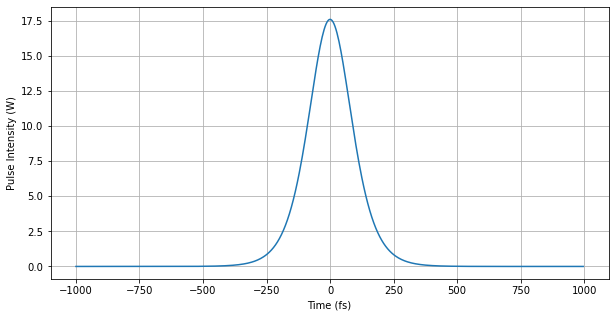

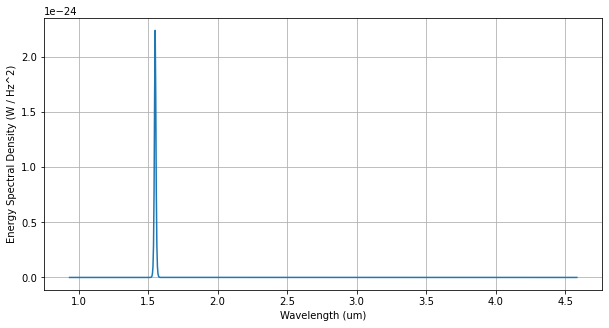

In [5]:
Tp = 200e-15 #Input pulse width (fs)
tau = Tp/1.76
rep_rate = 250e6
pump_pwr = 0.001 #Average pump power (W)
pulse = np.sqrt(0.88/rep_rate/Tp*pump_pwr)*sech(t/tau)
noise = 1e-10*np.random.normal(size=NFFT)

wla = 1.55e-6 #pump wavelength (um)
f0_pump = c/wla
wa = 2*pi*c/wla #Central angular frequency for pulse "a"
pump_in = nlo.pulse(t*1e15, pulse, wla*1e6)

pump_in.plot_magsq()
pump_in.plot_ESD_vs_wavelength()
print('Pulse energy = ', format(pump_in.energy_td()*1e12, '0.3e'), 'pJ')
print('Pulse energy = ', format(pump_in.energy_fd()*1e12, '0.3e'), 'pJ')

## SH pulse creation

2.138e-23 nJ
2.138e-23 nJ


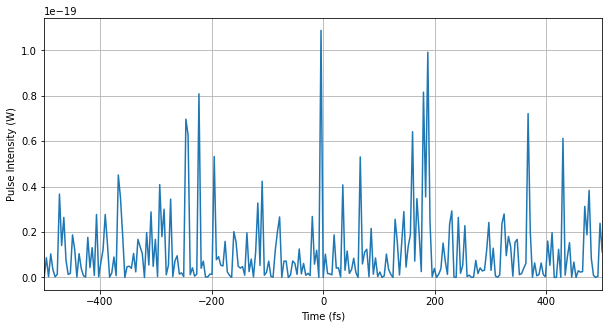

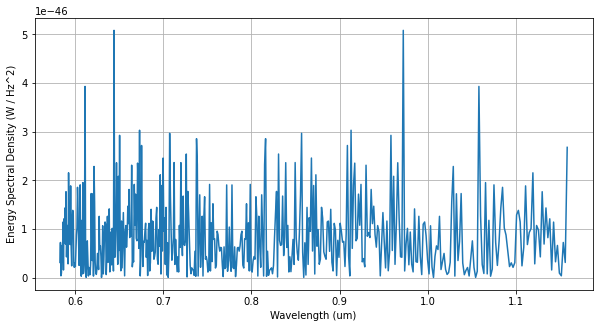

In [6]:
#Parameters
wlb = wla/2 #pump wavelength
f0_sh = c/wlb

#Pulse creation
sh_in = nlo.pulse(t*1e15, noise, wlb*1e6)

sh_in.plot_magsq(xlim=[-500,500])
sh_in.plot_ESD_vs_wavelength()
print(format(sh_in.energy_td()*1e9, '0.3e'), 'nJ')
print(format(sh_in.energy_fd()*1e9, '0.3e'), 'nJ')

## Waveguides

In [7]:
#Waveguide geometry
etch = 0.35
dridge = 0.7
dslab = dridge - etch
wridge = 1.5

### Dispersion operator for pump (1.55um)

Central Wavelength =  1.55 um
Central Frequency = 193.414 THz


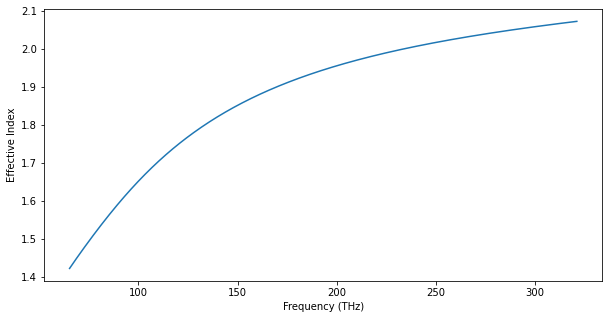

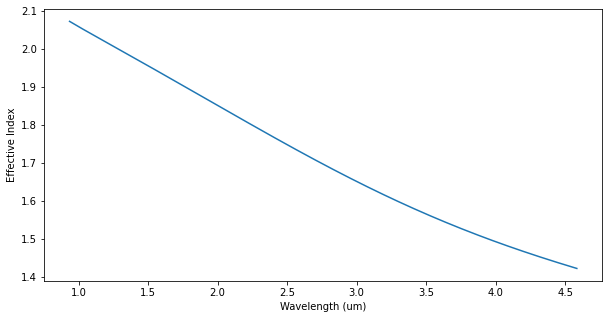

In [8]:
f = fftshift(pump_in.f)*1e12
f0 = pump_in.f0*1e12
fabs = f + f0
wl0 = c/f0*1e6
wls = c/fabs*1e6
print("Central Wavelength = ", wl0, "um")
print("Central Frequency = %0.3f THz" %(f0*1e-12))

#Effective index
neff_pump = np.zeros(f.shape)
for kf in range(f.size):
    freq = fabs[kf] #Actual frequency
    wl = c/freq*1e6
    #Material properties
    n0 = 1
    nLN = materials.refractive_index('LN_MgO_e', wl)
    nSiO2 = materials.refractive_index('SiO2', wl)
    #Effective index method
    n_slab = waveguides.neff_asymmetric_slab(n0, nLN, nSiO2, dslab, wl, mode='TE even', order=0)
    n_ridge = waveguides.neff_asymmetric_slab(n0, nLN, nSiO2, dridge, wl, mode='TE even', order=0)
    neff_pump[kf] = waveguides.neff_symmetric_slab(n_slab, n_ridge, wridge, wl, mode='TM even', order=0)
    
plt.plot(fabs*1e-12, neff_pump);
plt.xlabel('Frequency (THz)');
plt.ylabel('Effective Index');

fig = plt.figure()
plt.plot(wls, neff_pump);
plt.xlabel('Wavelength (um)');
plt.ylabel('Effective Index');

The dispersion operator is
$$
D = \exp(j\beta h),
$$
where $\beta = \omega n_{\mathrm{eff}} / c - \beta_0$.

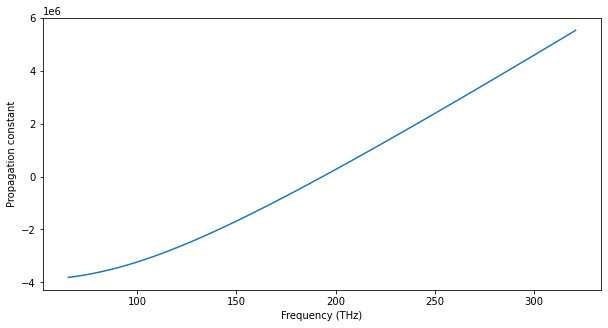

In [9]:
beta_pump = 2*pi*f*neff_pump/c
plt.plot(fabs*1e-12, beta_pump)
plt.xlabel('Frequency (THz)');
plt.ylabel('Propagation constant');

Dpump = np.exp(1j*beta_pump)

### Dispersion operator for second harmonic (0.775um)

Central Wavelength =  0.775 um
Central Frequency = 386.829 THz


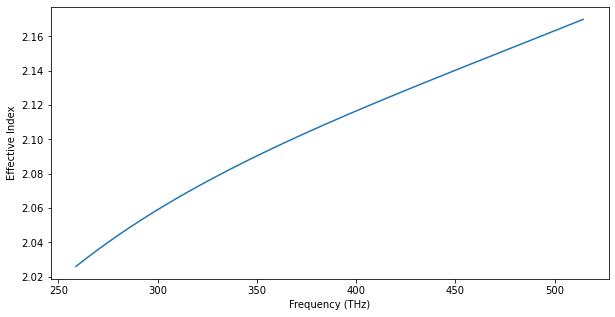

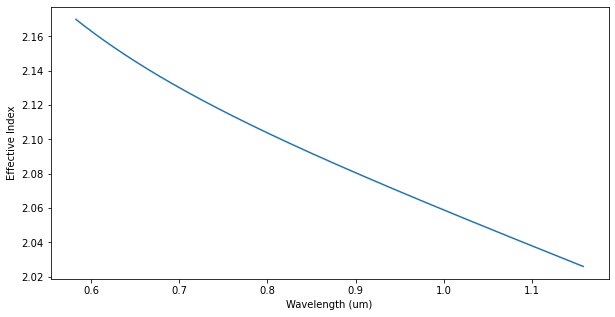

In [10]:
f = fftshift(sh_in.f)*1e12
f0 = sh_in.f0*1e12
fabs = f + f0
wl0 = c/f0*1e6
wls = c/fabs*1e6
print("Central Wavelength = ", wl0, "um")
print("Central Frequency = %0.3f THz" %(f0*1e-12))

#Effective index
neff_sh = np.zeros(f.shape)
for kf in range(f.size):
    freq = fabs[kf] #Actual frequency
    wl = c/freq*1e6
    #Material properties
    n0 = 1
    nLN = materials.refractive_index('LN_MgO_e', wl)
    nSiO2 = materials.refractive_index('SiO2', wl)
    #Effective index method
    n_slab = waveguides.neff_asymmetric_slab(n0, nLN, nSiO2, dslab, wl, mode='TE even', order=0)
    n_ridge = waveguides.neff_asymmetric_slab(n0, nLN, nSiO2, dridge, wl, mode='TE even', order=0)
    neff_sh[kf] = waveguides.neff_symmetric_slab(n_slab, n_ridge, wridge, wl, mode='TM even', order=0)
    
plt.plot(fabs*1e-12, neff_sh);
plt.xlabel('Frequency (THz)');
plt.ylabel('Effective Index');

fig = plt.figure()
plt.plot(wls, neff_sh);
plt.xlabel('Wavelength (um)');
plt.ylabel('Effective Index');

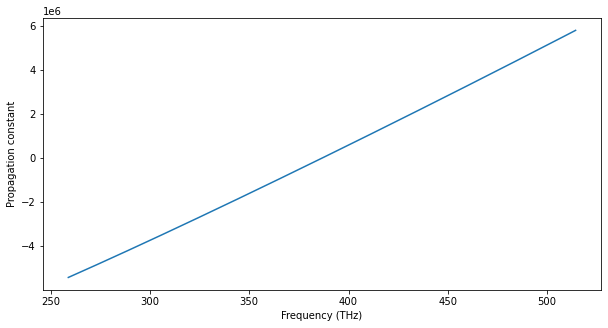

In [11]:
beta_sh = 2*pi*f*neff_sh/c
plt.plot(fabs*1e-12, beta_sh)
plt.xlabel('Frequency (THz)');
plt.ylabel('Propagation constant');

Dsh = np.exp(1j*beta_sh)

## Nonlinear  Stuff

In [12]:
def nonlinear_operator(a, b, nlc):
    f = -1j*ifft(nlc*fft(b*np.conj(a)))
    g = -1j*ifft(nlc*fft(a*a))
    return np.array([f,g])

In [13]:
def propagate(x, y):
    
    x_evol = 1j*np.zeros([t.size,steps+1])
    y_evol = 1j*np.zeros([t.size,steps+1])
    
    x_evol[:,0] = x
    y_evol[:,0] = y
    
    for kz in range(steps):
        #Linear step
        x = ifft(Da*fft(x))
        y = ifft(Db*fft(y))

        #Nonlinear step
        #Runge-Kutta 4th order
        [k1, l1] = h*nonlinear_operator(x,y,nlc)
        [k2, l2] = h*nonlinear_operator(x+k1/2,y+l1/2,nlc)
        [k3, l3] = h*nonlinear_operator(x+k2/2,y+l2/2,nlc)
        [k4, l4] = h*nonlinear_operator(x+k3,y+l3,nlc)

        x = x + (1/6)*(k1+2*k2+2*k3+k4)
        y = y + (1/6)*(l1+2*l2+2*l3+l4)
        
        x_evol[:,kz+1] = x
        y_evol[:,kz+1] = y

    return x, y, x_evol, y_evol

## Nonlinear element

Similarly, we create a nonlinear element.

In [14]:
#Crystal parameters
L = 2e-3
h = 1e-3/50
steps = int(L/h)

print('step size = %0.2f um' %(h*1e6))
print('Number of steps = %i' %(steps))

#Dispersion operators
Da = fftshift(Dpump**h)
Db = fftshift(Dsh**h)

#Nonlinear coupling
eta0 = 1000 # (%/W/cm^2)
eta0 = eta0*(1e2)**2 #(%/W/m^2)
nlc = np.sqrt(eta0)

step size = 20.00 um
Number of steps = 100


## Single pass

In [15]:
a_in = pump_in.e
b_in = sh_in.e
[a, b, a_evol, b_evol] = propagate(a_in, b_in)

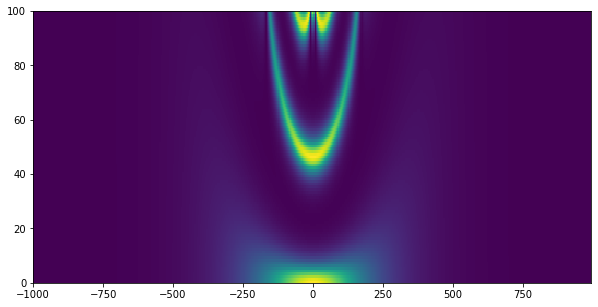

In [16]:
X,Y = np.meshgrid(t*1e15, np.arange(steps+1))
plt.pcolormesh(X, Y, (np.transpose(np.abs(a_evol))))

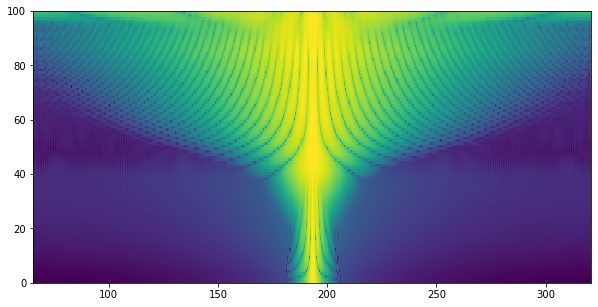

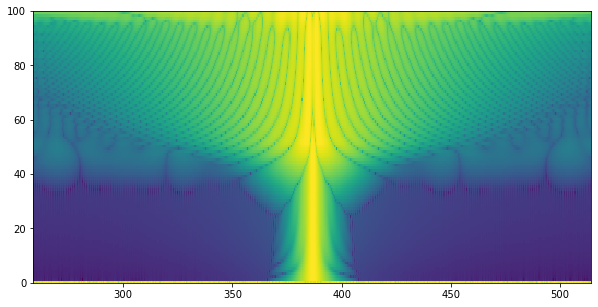

In [17]:
fabs = f0_pump + f
X,Y = np.meshgrid(fabs*1e-12, np.arange(steps+1))

fabs = f0_sh + f
X2,Y2 = np.meshgrid(fabs*1e-12, np.arange(steps+1))

A_evol = np.zeros((t.size, steps+1))
B_evol = np.zeros((t.size, steps+1))

for k in range(steps+1):
    x = a_evol[:,k]
    _ , Xesd = nlo.get_esd_dB(t*1e15,x)
    A_evol[:,k] = Xesd
    
    x = b_evol[:,k]
    _ , Xesd = nlo.get_esd_dB(t*1e15,x)
    B_evol[:,k] = Xesd

plt.figure()
plt.pcolormesh(X, Y, (np.transpose(A_evol)))

plt.figure()
plt.pcolormesh(X2, Y2, (np.transpose(B_evol)))

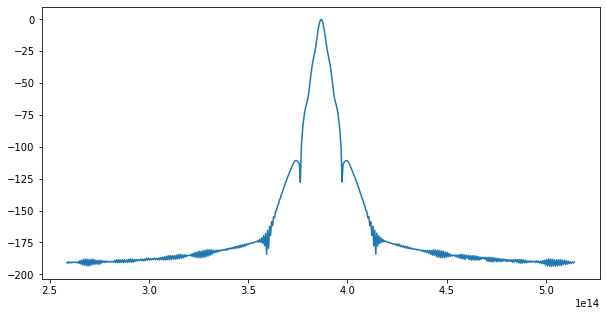

In [18]:
k = 30
x = b_evol[:,k]
_ , Xesd = nlo.get_esd_dB(t*1e15,x)
# B_evol[:,k] = Xesd
plt.plot(fabs, Xesd)

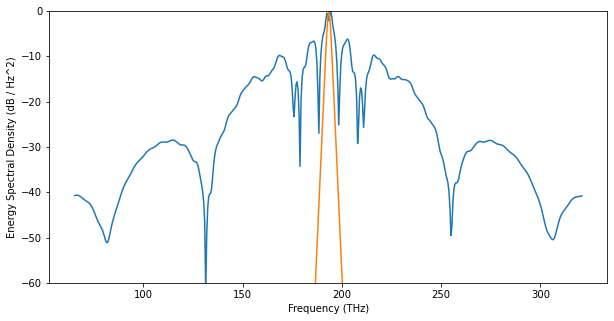

In [19]:
f0a = f0_pump*1e-12
ax1 = nlo.plot_ESD_dB_absfreq(t*1e15, a, f0a)
ax1 = nlo.plot_ESD_dB_absfreq(t*1e15, a_in, f0a, ax=ax1, ylim=[-60,0])

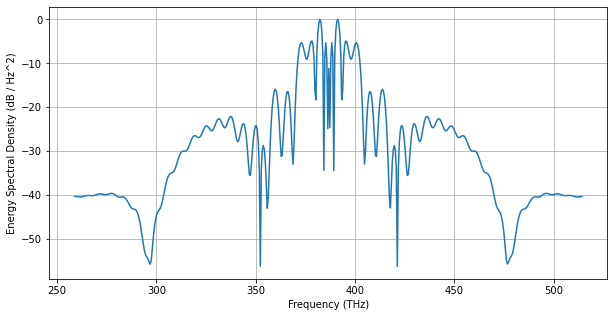

In [20]:
f0b = f0_sh*1e-12
nlo.plot_ESD_dB_absfreq(t*1e15, b, f0b)

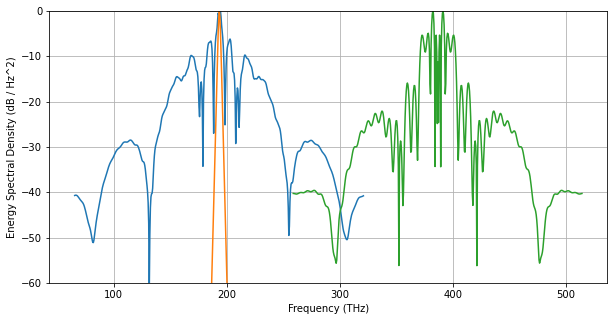

In [21]:
f0a = f0_pump*1e-12
ax1 = nlo.plot_ESD_dB_absfreq(t*1e15, a, f0a)
ax1 = nlo.plot_ESD_dB_absfreq(t*1e15, a_in, f0a, ax=ax1, ylim=[-60,0])
f0b = f0_sh*1e-12
nlo.plot_ESD_dB_absfreq(t*1e15, b, f0b, ax=ax1)